# Tutorial: Hyperparameter Sensitivity

We want to perform basic tests on the hypothesis "how good is our in-sample optimization process" considering the out-of-sample testing.

We shall perform a experiment, and vary the optained $(k,d)_{Opt}$ - then we evaluate this delta impact on the out-of-sample measures.

By Kevin Pergher, December the 24th, 2025.

In [ ]:
import pandas
import datetime
import numpy
import warnings

warnings.filterwarnings("ignore")

from OHRP import OHRP

# Extract the Dataset
X = pandas.read_csv('datasets/IBOV_equity_closing_prices.csv', index_col = 0, parse_dates=True)
X.index = pandas.to_datetime(X.index, format='%Y-%m-%d')

# Indices/Benchmarks
benchmarks = ['IBOV', 'SELIC']

Xindices = X[benchmarks].copy()

X.drop(columns=benchmarks, inplace = True)

# Separate Indices and Stocks
Xstocks = X.copy()
Xstocks.dropna(how='all', axis=0, inplace=True)
Xindices = Xindices.loc[Xstocks.index,:].copy()


In [ ]:
def calc_hhi(weights: pandas.Series, normalize: bool = True) -> float:
    """
    Calculate the Herfindahl–Hirschman Index (HHI) for a weight vector.

    Parameters
    ----------
    weights : pd.Series
        Portfolio weights or any vector of values.
    normalize : bool, optional (default=True)
        If True, normalize weights so their absolute sum equals 1.

    Returns
    -------
    float
        Herfindahl–Hirschman Index (HHI).
    """
    w = weights.astype(float).copy()
    if normalize:
        w = w / w.abs().sum()
    return float((w ** 2).sum())

# Time we want to start the rolling window
# Vary as you want or need
initialTime = 1984

# Windows we want to test
for WL in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:

    print(f"Processing WL = {WL}")

    t  = initialTime

    windowLength = int(WL * 252)

    holdingPeriod = 21

    # Available hyperparameters configurations
    list_of_d = [5,10,15,20,25,30,35]
    list_of_k = [1,3,5,7,9,11,13]

    # Deltas we want to test
    delta_of_d = [-15,-10,-5,0, 5,10,15]
    delta_of_k = [-5,-3,-1,0, 1,3,5]

    # Folder we want to save results
    path = f"results/empirical_sensibility_ohrp_WL{str(WL)}.csv"
    try:
        listOfDates = pandas.read_csv(path).BuildPort.unique().tolist()
    except FileNotFoundError:
        listOfDates = []

    while t < (Xstocks.shape[0] - holdingPeriod):
        
        print(f"Processing t = {t} / {Xstocks.shape[0]}")
        
        # In-sample Data
        Xn = Xstocks.iloc[(t-windowLength):t,:].copy()
        # Out-of-sample Data
        Yn = Xstocks.iloc[t-1:t+holdingPeriod-1,:].copy()
 
        if str(Yn.index[1].date()) in listOfDates:
            t += holdingPeriod
            continue

        # Tickers with data on t
        activeFilter = ~pandas.isna(Xn.iloc[-1,:])
        activeFilter = activeFilter[activeFilter].index.tolist()
        Xn = Xn[activeFilter]
        Xn.dropna(axis = 0, how = 'all', inplace = True)
        Xn.dropna(axis = 1, thresh = int(0.9 * windowLength), inplace = True)
        Xn = Xn.pct_change().fillna(0)
        # Volatility filter - Some prices are manteined constant at YaHoo
        volatility = Xn.std(axis = 0)
        volatility = volatility[volatility > 0]
        Xn = Xn[volatility.index.tolist()]

        # Out-of-sample data
        Yn = Yn[Xn.columns.tolist()]
        Yn = Yn.pct_change().fillna(0)
        # Benchmark
        SELIC = Xindices.loc[Yn.index, 'SELIC'].copy()
        SELIC = SELIC.pct_change().fillna(0)
        # Drop first row (only zeros)
        Xn = Xn.iloc[1:,:].copy()
        Yn = Yn.iloc[1:,:].copy()
        SELIC = SELIC.iloc[1:].copy()

        # Perform OHRP
        ohrp = OHRP(codep = "pearson", linkage = "ward")
        weightsOHRP = ohrp.run(
            X = Xn.copy(), 
            k = list_of_k, 
            d = list_of_d, 
            r = [0.9]
        )

        outSamplePortfolioOHRP = (Yn * weightsOHRP).sum(axis = 1)

        aux = []
        aux.append(Yn.index[0])
        aux.append(0)
        aux.append(0)
        aux.append(calc_hhi(weights = weightsOHRP))
        aux.append(numpy.std(outSamplePortfolioOHRP) * numpy.sqrt(252))
        aux.append((numpy.mean(outSamplePortfolioOHRP) - numpy.mean(SELIC)) / (numpy.std(outSamplePortfolioOHRP) * numpy.sqrt(252)))
        aux = pandas.DataFrame(
            [aux], columns = ["BuildPort", "K", "D", "HHI", "SD", "SR"]
        )
        if t == initialTime:
            aux.to_csv(path, mode='a', header = True, index = False)
        else:
            aux.to_csv(path, mode='a', header = False, index = False)

        # Vary k and d around the best hyperparameters
        # Attention: This is not the most efficient way to do it, but it is easier to understand
        for d in delta_of_d:

            for k in delta_of_k:

                k_aux = ohrp._bestHyperparams['k'] + k
                d_aux = ohrp._bestHyperparams['d'] + d

                if k_aux < list_of_k[0]:
                    k_aux = list_of_k[0]
                elif k_aux > list_of_k[-1]:
                    k_aux = list_of_k[-1]

                if d_aux < list_of_d[0]:
                    d_aux = list_of_d[0]
                elif d_aux > list_of_d[-1]:
                    d_aux = list_of_d[-1]

                weightsOHRP = OHRP(codep = "pearson", linkage = "ward").run(
                    X = Xn.copy(), 
                    k = k_aux, 
                    d = d_aux, 
                    r = [0.9]
                )

                outSamplePortfolioOHRP = (Yn * weightsOHRP).sum(axis = 1)
                
                aux = []
                aux.append(Yn.index[0])
                aux.append(k)
                aux.append(d)
                aux.append(calc_hhi(weights = weightsOHRP))
                aux.append(numpy.std(outSamplePortfolioOHRP) * numpy.sqrt(252))
                aux.append((numpy.mean(outSamplePortfolioOHRP) - numpy.mean(SELIC)) / (numpy.std(outSamplePortfolioOHRP) * numpy.sqrt(252)))
                aux = pandas.DataFrame(
                    [aux], columns = ["BuildPort", "K", "D", "HHI", "SD", "SR"]
                )
                # Save the data
                aux.to_csv(path, mode='a', header = False, index = False)

        t += holdingPeriod

Processing WL = 1.0
Processing t = 1984 / 6127
Processing t = 2005 / 6127
Processing t = 2026 / 6127
Processing t = 2047 / 6127
Processing t = 2068 / 6127
Processing t = 2089 / 6127
Processing t = 2110 / 6127
Processing t = 2131 / 6127
Processing t = 2152 / 6127
Processing t = 2173 / 6127
Processing t = 2194 / 6127
Processing t = 2215 / 6127
Processing t = 2236 / 6127
Processing t = 2257 / 6127
Processing t = 2278 / 6127
Processing t = 2299 / 6127
Processing t = 2320 / 6127
Processing t = 2341 / 6127
Processing t = 2362 / 6127
Processing t = 2383 / 6127
Processing t = 2404 / 6127
Processing t = 2425 / 6127
Processing t = 2446 / 6127
Processing t = 2467 / 6127
Processing t = 2488 / 6127
Processing t = 2509 / 6127
Processing t = 2530 / 6127
Processing t = 2551 / 6127
Processing t = 2572 / 6127
Processing t = 2593 / 6127
Processing t = 2614 / 6127
Processing t = 2635 / 6127
Processing t = 2656 / 6127
Processing t = 2677 / 6127
Processing t = 2698 / 6127
Processing t = 2719 / 6127
Processi

Visualizing the effect of hyperparameter changing on a given window $WL$

Results for WL = 2.5 years:
Delta D p/ SD: -6.6E-02   | Delta K p/ SD: -5.9E-02
Delta D p/ SR: 3.4E-05   | Delta K p/ SR: 7.3E-05
Delta D p/ HHI: -2.6E-01 | Delta K p/ HHI: 7.8E-02


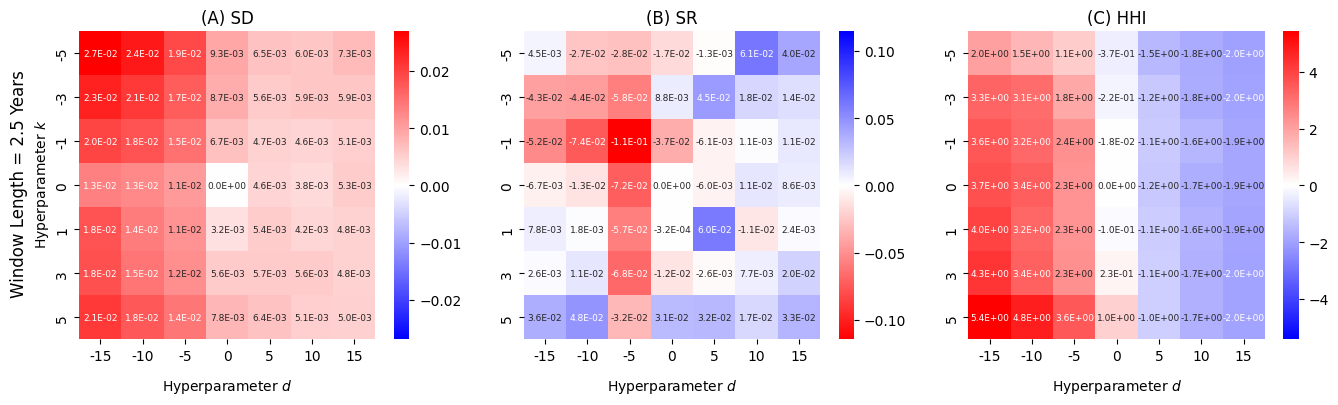

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
import numpy as np

def getTable(df, value_column: str, aggfunc = 'mean'):
    dfAux = pandas.pivot_table(
        data    = df,
        values  = value_column,
        index   = 'K',
        columns = 'D',
        aggfunc = aggfunc
    )
    dfAux.index = dfAux.index.astype(int).tolist()
    dfAux.columns = dfAux.columns.astype(int).tolist()
    #dfAux -= dfAux.loc[0,0]
    return dfAux

def sci_fmt(x):
    # Always use scientific notation, even for zero
    return f"{x:.1E}"  # Example: 0 -> 0.0E+00

def plot_heatmaps_row(data_list, titles=None, wl="1.0"):
    n = len(data_list)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))

    plt.subplots_adjust(left=0.06)

    if n == 1:
        axes = [axes]

    base_cmap = plt.get_cmap("bwr")

    for i, (data, ax) in enumerate(zip(data_list, axes)):

        vmax = np.nanmax(np.abs(data))
        vmin = -vmax
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

        # (1) NEW: same colorscale in heatmap 3 as in 1
        cmap = base_cmap if (i == 0 or i == 2) else base_cmap.reversed()

        sns.heatmap(
            data,
            ax=ax,
            cmap=cmap,
            norm=norm,
            annot=True,
            fmt="",
            cbar=True,
            annot_kws={"size": 6.5}
        )

        for t, real_val in zip(ax.texts, data.to_numpy().flatten()):
            t.set_text(sci_fmt(real_val))

        if titles:
            ax.set_title(titles[i], fontsize=12)

        # (2) NEW: label under each heatmap
        ax.set_xlabel(r"Hyperparameter $d$", fontsize=10, labelpad=10)

    # Y-axis title + subtitle
    y_center = 0.50
    x_pos = 0.02

    fig.text(
        x_pos, y_center,
        f"Window Length = {wl} Years",
        fontsize=12,
        rotation='vertical',
        va='center',
        ha='center',
        transform=fig.transFigure
    )

    fig.text(
        0.035, y_center,
        r"Hyperparameter $k$",
        fontsize=10,
        rotation='vertical',
        va='center',
        ha='center',
        transform=fig.transFigure
    )

    plt.show()

# List of windows we want to analyze
for WL in [2.5]:

    # Data previously saved
    df = pandas.read_csv(f"results/empirical_sensibility_ohrp_WL{str(WL)}.csv")

    newDf = pandas.DataFrame()
    for date in df.BuildPort.unique().tolist():

        auxDf = df[df.BuildPort == date].copy()
        auxDf.HHI -= auxDf.HHI[(auxDf.K == 0) & (auxDf.D == 0)].values[0]
        auxDf.SD  -= auxDf.SD[(auxDf.K == 0) & (auxDf.D == 0)].values[0]
        auxDf.SR  -= auxDf.SR[(auxDf.K == 0) & (auxDf.D == 0)].values[0]
        newDf = pandas.concat([newDf, auxDf], ignore_index=True)

    # Extract mean values on all portfolios
    dfSTD = getTable(newDf, 'SD', aggfunc = 'mean')
    dfSHR = getTable(newDf, 'SR', aggfunc = 'mean') * 100
    dfHHI = getTable(newDf, 'HHI', aggfunc = 'mean') * 100

    deltaSD_k  = numpy.mean(newDf.SD[newDf.K != 0]/newDf.K[newDf.K != 0]) * 100
    deltaSR_k  = numpy.mean(newDf.SR[newDf.K != 0]/newDf.K[newDf.K != 0])
    deltaHII_k = numpy.mean(newDf.HHI[newDf.K != 0]/newDf.K[newDf.K != 0]) * 100

    deltaSD_d  = numpy.mean(newDf.SD[newDf.D != 0]/newDf.D[newDf.D != 0]) * 100
    deltaSR_d  = numpy.mean(newDf.SR[newDf.D != 0]/newDf.D[newDf.D != 0])
    deltaHII_d = numpy.mean(newDf.HHI[newDf.D != 0]/newDf.D[newDf.D != 0]) * 100

    print(f"Results for WL = {WL} years:")

    print(f"Delta D p/ SD: {sci_fmt(deltaSD_d.round(4))}   | Delta K p/ SD: {sci_fmt(deltaSD_k.round(4))}")
    print(f"Delta D p/ SR: {sci_fmt(deltaSR_d)}   | Delta K p/ SR: {sci_fmt(deltaSR_k)}")
    print(f"Delta D p/ HHI: {sci_fmt(deltaHII_d.round(4))} | Delta K p/ HHI: {sci_fmt(deltaHII_k.round(4))}")

    # Plot a Heatmap Row
    plot_heatmaps_row(
        data_list=[dfSTD, dfSHR, dfHHI],
        titles=["(A) SD", "(B) SR", "(C) HHI"],
        wl=str(WL)
    )
    